# Setup

In [1]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from pathlib import Path
import cv2
import torch
from torch import cuda
import os
import numpy as np
import random
import numpy.ma as ma
import json
from typing import Any, Dict, Generator, List
import sys

PYTORCH_NO_CUDA_MEMORY_CACHING=1
np.set_printoptions(precision=9)

sys.path.append('../') # workaround for lack of relative import in notebooks
from dataset import dataset_utils, voc_annotate_and_Roboflow_export
from sam_predictor import predictor_utils, astro_sam #, residualAttentionBlock
from losses import loss_utils, metrics_utils
from yolo_predictor import yolo_predictor_utils

In [2]:
kfold_iter = 0

device_id = 0
batch_size = 10
lr=6e-5
wd=0.0005
wandb_track = False
torch.cuda.set_device(device_id)

In [3]:
if wandb_track:
    from datetime import datetime
    # !pip install wandb
    # !wandb login --relogin
    import wandb
    wandb.login()
    run = wandb.init(project="yolo-sam", name=f"yolo-sam {datetime.now()}")

## Dataset

In [4]:
# yolo_dataset_path = f'../roboflow_datasets/xmm_om_artefacts-4-YOLO_no_augm/'
yolo_dataset_path = f'../../XAMI-dataset/mskf_YOLO_{kfold_iter}/'

In [5]:
import yaml

with open(yolo_dataset_path+f"data.yaml", 'r') as stream:
    yam_data = yaml.safe_load(stream) # dictionary with keys 'names', 'nc', 'train', 'val'

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
print(classes)

coco_data_path = f'../../XAMI-dataset/mskf_{kfold_iter}/'
annotations_file = '_annotations.coco.json'

with open(coco_data_path+'train/'+annotations_file, 'r') as f1, open(coco_data_path+'valid/'+annotations_file, 'r') as f2:
    train_coco_data = json.load(f1)
    valid_coco_data = json.load(f2)

{0: 'central-ring', 1: 'other', 2: 'read-out-streak', 3: 'smoke-ring', 4: 'star-loop'}


In [6]:
train_dir = yolo_dataset_path+f'train/images/'
valid_dir = yolo_dataset_path+f'valid/images/'

train_image_files = os.listdir(train_dir)
valid_image_files = os.listdir(valid_dir)

# Model setup

In [7]:
import sys
import PIL
from PIL import Image
sys.path.append('/workspace/raid/OM_DeepLearning/XAMI/mobile_sam/')
from ft_mobile_sam import sam_model_registry, SamPredictor

device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"

mobile_sam_checkpoint = '../output_sam/ft_mobile_sam_final_2024-05-05 18:38:00.526813.pth'
yolov8_pretrained_model = YOLO(f'../train/yolov8-segm-{kfold_iter}/yolov8n-seg2/weights/last.pt');
yolov8_pretrained_model.to(f'cuda:{device_id}');

mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device)
predictor = SamPredictor(mobile_sam_model)

# # Residual Attention Block
# residual_block = residualAttentionBlock.ResidualAttentionBlock(d_model=256, n_head=8, mlp_ratio=4.0).to(device)
# residual_block.load_state_dict(torch.load('../output_sam/residual_attn_blk_2024-05-10 08:05:54.498084_best.pth'))

# for name, param in residual_block.named_parameters():
# 	param.requires_grad = True 

/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing na

In [8]:
astrosam_model = astro_sam.AstroSAM(mobile_sam_model, device, predictor)

In [9]:
for name, param in mobile_sam_model.named_parameters():
    params_to_train = ['mask_tokens', 'output_upscaling', 'output_hypernetworks_mlps', 'iou_prediction_head']
    if 'mask_decoder' in name: # and any(s in name for s in params_to_train):
        param.requires_grad = True
    else:
        param.requires_grad = False
        
print(f"🚀 The model has {sum(p.numel() for p in astrosam_model.model.parameters() if p.requires_grad)} trainable parameters.")
# print(f"🚀 The residual attention block has {sum(p.numel() for p in astrosam_model.residualAttentionBlock.parameters() if p.requires_grad)} trainable parameters.\n")

predictor_utils.check_requires_grad(astrosam_model.model)
# predictor_utils.check_requires_grad(astrosam_model.residualAttentionBlock)

🚀 The model has 4058340 trainable parameters.
❌ Param image_encoder.patch_embed.seq.0.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.bias  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv3.c.weight

In [10]:
import time
import torch.nn.functional as F
import tqdm
from tqdm import tqdm

train_num_batches = len(train_image_files) // batch_size
valid_num_batches = len(valid_image_files) // batch_size
parameters_to_optimize = [param for param in mobile_sam_model.mask_decoder.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(parameters_to_optimize, lr=lr, weight_decay=wd)

## Define metrics

In [11]:
from torch import tensor
from torchmetrics.detection import MeanAveragePrecision
from pprint import pprint

metric_thresholds = [[0.5], [0.75], [0.5, 0.75, 0.9]]

# Train

In [12]:
from collections import defaultdict

best_valid_loss = float('inf')
num_epochs = 1
n_epochs_stop = 5 + num_epochs//10
all_metrics = defaultdict(dict)
compute_metrics = True

In [13]:
# Intro
predictor_utils.print_training_intro(
    train_image_files, valid_image_files, device, metric_thresholds, num_epochs, 
    batch_size, lr, wd, wandb_track, mobile_sam_model, 'AdamW')

# Training loop
for epoch in range(num_epochs):

    # Train
    astrosam_model.model.train()
    # astrosam_model.residualAttentionBlock.train()
    train_results = astrosam_model.run_yolo_sam_epoch(
        yolov8_pretrained_model,
        phase='val',
        batch_size=batch_size, 
        image_files=train_image_files, 
        images_dir=train_dir, 
        num_batches=train_num_batches,
        optimizer=None) 
    
    epoch_sam_loss_train, epoch_yolo_loss_train, train_preds, train_gts=train_results[:4]
    train_gt_classes, train_pred_classes, train_all_iou_scores, train_mask_areas, _=train_results[4:]

    # Validate
    astrosam_model.model.eval()
    # astrosam_model.residualAttentionBlock.eval()
    
    with torch.no_grad():
        valid_results = astrosam_model.run_yolo_sam_epoch(
            yolov8_pretrained_model,
            phase='val',
            batch_size=batch_size, 
            image_files=valid_image_files, 
            images_dir=valid_dir, 
            num_batches=valid_num_batches,
            optimizer=None) 

    epoch_sam_loss_val, epoch_yolo_loss_val, valid_preds, valid_gts=valid_results[:4]
    valid_gt_classes, valid_pred_classes, valid_all_iou_scores, valid_mask_areas, pred_images=valid_results[4:]

    # Early stopping                                                                                
    if epoch_sam_loss_val < best_valid_loss:
        best_valid_loss = epoch_sam_loss_val
        best_model = astrosam_model.model
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping initiated.")
            early_stop = True
            break
            
    # Metrics
    if compute_metrics:
        for threshold in tqdm(metric_thresholds, desc="(Metrics) Processing thresholds", bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
            metric = MeanAveragePrecision(
            iou_type = "segm", 
            iou_thresholds = threshold, 
            max_detection_thresholds=[1, 10, 100],
            class_metrics=True,
            extended_summary=False)
            
            train_metrics = metrics_utils.mAP_metrics(metric,
            train_preds,
            train_gts, 
            train_gt_classes, 
            train_pred_classes, 
            train_all_iou_scores,
            train_mask_areas,
            show_metrics=False) 
                
            valid_metrics = metrics_utils.mAP_metrics(metric,
                    valid_preds,
                    valid_gts, 
                    valid_gt_classes, 
                    valid_pred_classes, 
                    valid_all_iou_scores,
                    valid_mask_areas,
                    show_metrics=False)
        
            all_metrics[tuple(threshold)] = {'train': train_metrics, 'valid': valid_metrics}

    # Prints
    if not wandb_track or not compute_metrics:
        wandb = None
    predictor_utils.prints_and_wandb(epoch_sam_loss_train, epoch_sam_loss_val, all_metrics, wandb)

# Checkpoint save
torch.save(best_model.state_dict(), f'yolo_sam_final.pth')

# Finish wandb run
if wandb_track:
    run.finish()

Model Training Configuration:
 - Training images: 791
 - Validation images: 264
 - Number of Epochs: 1
 - Batch Size: 10
 - Learning Rate: 6e-05
 - Weight Decay: 0.0005
 - Device: cuda:0
 - mAP thresholds: [[0.5], [0.75], [0.5, 0.75, 0.9]]
 - Early Stopping: Stop if no improvement after 5 epochs.
 - Weights & Biases Tracking: Disabled.
 - Optimizer: AdamW.
 - Total Trainable Parameters: 4,058,340


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:34<00:00, 11.53s/it]                                                                   

Train loss: 0.4022
Validation loss: 0.4064
Train mAP50: tensor(0.9271) Train mAP75: tensor(0.6107) Train mAP50-90: tensor(0.5526)
Valid mAP50: tensor(0.8506) Valid mAP75: tensor(0.5529) Valid mAP50-90: tensor(0.5022)


In [29]:
all_metrics 

defaultdict(dict,
            {(0.5,): {'train': {'map': tensor(0.9271),
               'map_50': tensor(0.9271),
               'map_75': tensor(-1.),
               'map_small': tensor(0.8799),
               'map_medium': tensor(0.9376),
               'map_large': tensor(0.9924),
               'mar_1': tensor(0.4729),
               'mar_10': tensor(0.9252),
               'mar_100': tensor(0.9445),
               'mar_small': tensor(0.8987),
               'mar_medium': tensor(0.9561),
               'mar_large': tensor(1.),
               'map_per_class': tensor([0.9997, 0.8991, 0.8075, 0.9637, 0.9656]),
               'mar_100_per_class': tensor([1.0000, 0.9062, 0.8717, 0.9737, 0.9710]),
               'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)},
              'valid': {'map': tensor(0.8506),
               'map_50': tensor(0.8506),
               'map_75': tensor(-1.),
               'map_small': tensor(0.8463),
               'map_medium': tensor(0.8367),
         

In [ ]:
# 1 Epoch metrics:
# Train loss: 0.4041
# Validation loss: 0.3942
# Train mAP50: tensor(0.8366) Train mAP75: tensor(0.5383) Train mAP50-90: tensor(0.4974)
# Valid mAP50: tensor(0.8363) Valid mAP75: tensor(0.5495) Valid mAP50-90: tensor(0.4974)

# Metrics visualization

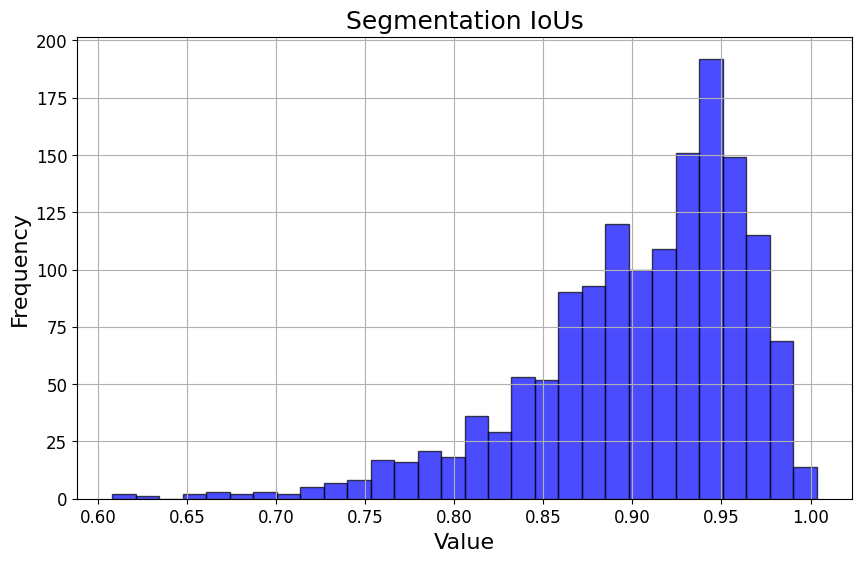

In [30]:
# IoUs frequency

train_all_ious_flatten, train_mask_areas_flatten = metrics_utils.flatten_ious_areas(train_pred_classes, train_all_iou_scores, train_mask_areas)
valid_all_ious_flatten, valid_mask_areas_flatten = metrics_utils.flatten_ious_areas(valid_pred_classes, valid_all_iou_scores, valid_mask_areas)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_all_ious_flatten, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Segmentation IoUs')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

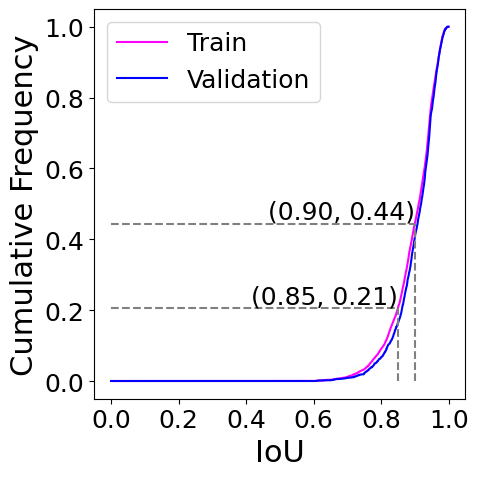

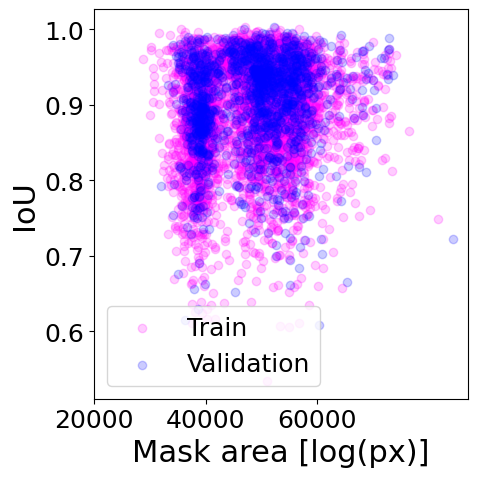

In [31]:
import numpy as np
from matplotlib import rcParams

rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 14, 'font.family':'sans-serif'})

ious_train = train_all_ious_flatten
ious_valid = valid_all_ious_flatten
areas_train = train_mask_areas_flatten
areas_valid = valid_mask_areas_flatten

vals_train, base_train = np.histogram(ious_train, bins=1000, range=(0, 1), density=True)
cumulative_train = np.cumsum(vals_train * np.diff(base_train))
vals_valid, base_valid = np.histogram(ious_valid, bins=1000, range=(0, 1), density=True)
cumulative_valid = np.cumsum(vals_valid * np.diff(base_valid))

plt.figure(figsize=(5, 5))
plt.plot(base_train[:-1], cumulative_train, label='Train', color='magenta')
plt.plot(base_valid[:-1], cumulative_valid, label='Validation', color='blue')

quartiles_y = np.quantile(cumulative_train, [0.85, 0.9])
quartiles_x = np.interp(quartiles_y, cumulative_train, base_train[:-1])

for qx, qy in zip(quartiles_x, quartiles_y):
    plt.hlines(qy, xmin=0, xmax=qx, colors='grey', linestyles='dashed')
    plt.vlines(qx, ymin=0, ymax=qy, colors='grey', linestyles='dashed')
    plt.text(qx, qy, f'({qx:.2f}, {qy:.2f})', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('IoU', fontsize=22)
plt.ylabel('Cumulative Frequency', fontsize=22)
plt.legend(fontsize=18, loc='upper left')
plt.tight_layout()
plt.savefig('../plots/cdf_ious.png', dpi=500)
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(np.log(areas_train), ious_train, alpha=0.2, label='Train', color='magenta')
plt.scatter(np.log(areas_valid), ious_valid, alpha=0.2, label='Validation', color='blue')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
x_ticks_positions = np.array([20000, 40000, 60000])*(np.max(np.log(areas_train))- np.min(np.log(areas_train)))/(np.max(areas_train)-np.min(areas_train))   # show orignal ticks but log plot
x_ticks_labels = ['20000', '40000', '60000']

plt.xticks(x_ticks_positions, x_ticks_labels, fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Mask area [log(px)]', fontsize=22)
plt.ylabel('IoU', fontsize=22)
plt.legend(fontsize=18, loc='lower left') #, bbox_to_anchor=(1, 0.04))
plt.tight_layout()
plt.savefig('../plots/ious_and_areas_log.png', dpi=500)
plt.show()

In [32]:
np.min(ious_train), np.min(ious_valid)

(0.534175, 0.6080458)

In [33]:
np.min(ious_train), np.max(ious_train), np.min(ious_valid), np.max(ious_valid)

(0.534175, 1.0035748, 0.6080458, 1.0035363)

### IoU TP FP FN plot (~29s)

Indices: [82, 73, 6, 80, 220] Images: ['S0300890101_B_png.rf.8e0da1df1e06360e1c3dcbbcb07314ea.jpg', 'S0863230101_V_png.rf.f63dcdfb2eb544c7b6b5680a2d7ca51c.jpg', 'S0021140201_L_png.rf.171df59291b94edefe15bd841e4cd61c.jpg', 'S0674491501_L_png.rf.9541e9021408a731d1eddd30dfb6c367.jpg', 'S0673002343_L_png.rf.26d17cc0b0b0b2a1871ad34b7b3b364b.jpg']
Mean IoU: 0.94502157 std: 0.023483302
Mean IoU: 0.9343209 std: 0.02918547
Mean IoU: 0.92911 std: 0.03038659
Mean IoU: 0.87376666 std: 0.05432862
Mean IoU: 0.9280185 std: 0.011428595

Plotting...


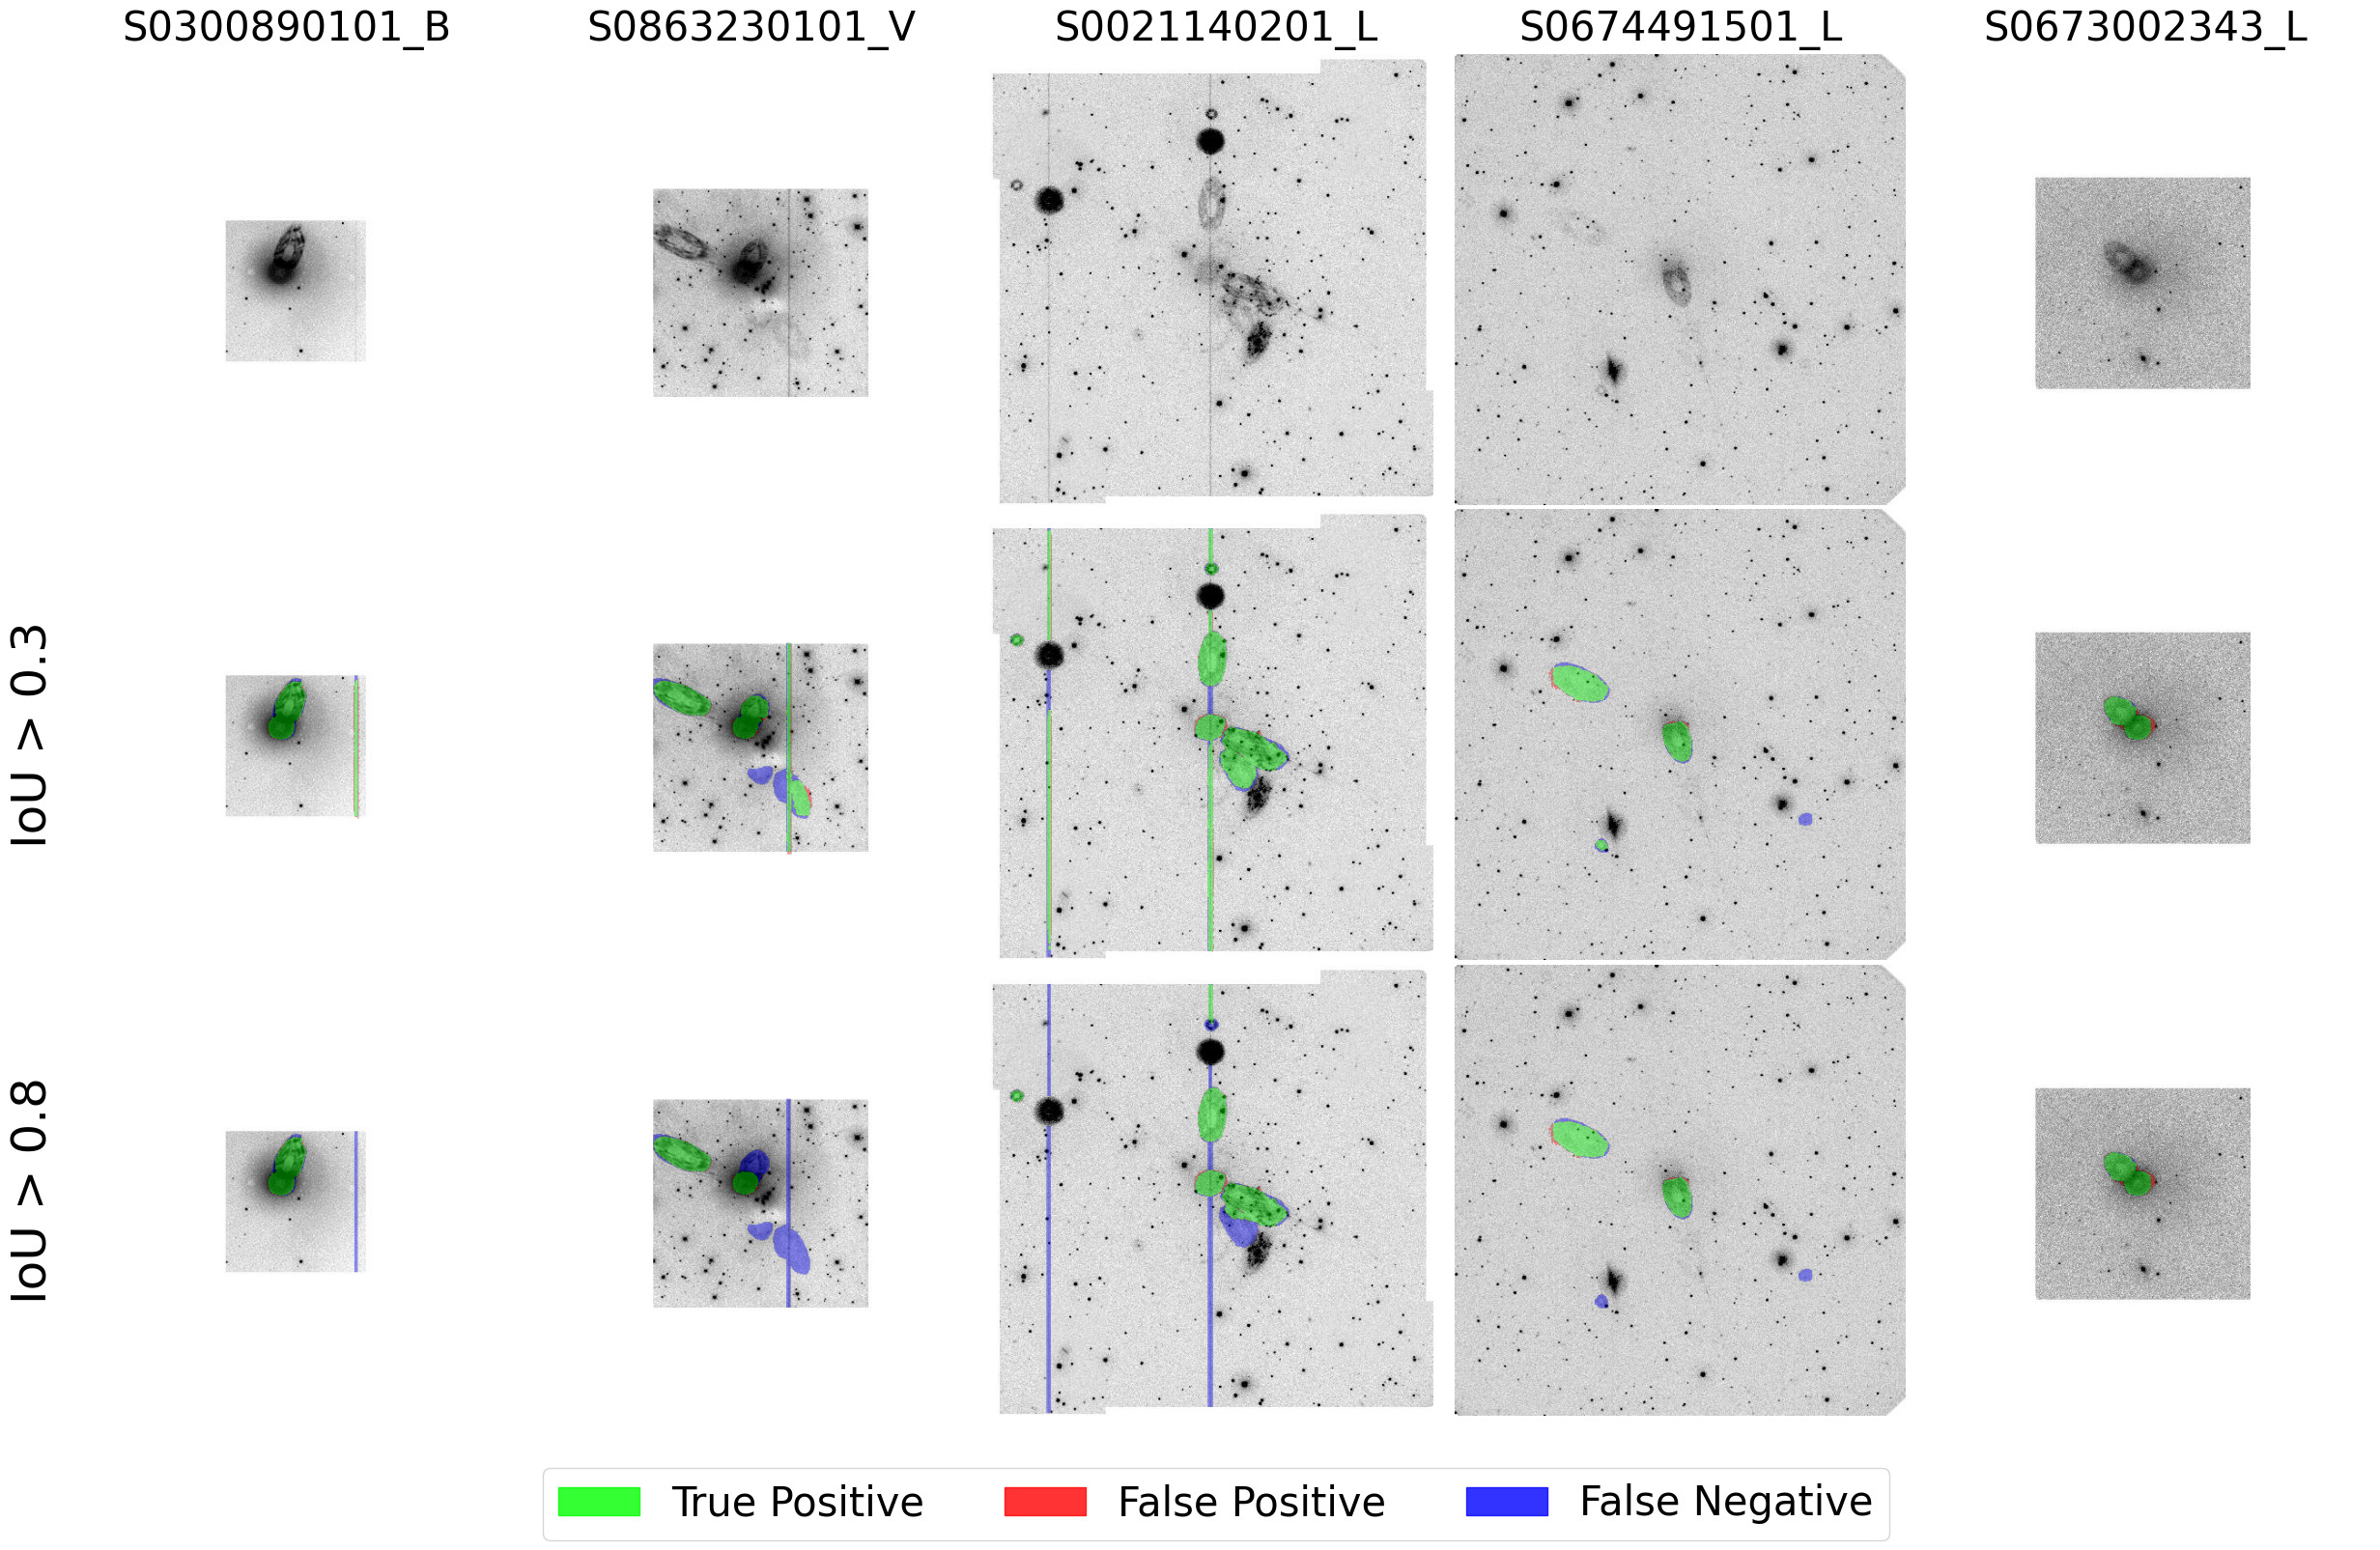

In [34]:
import random
import matplotlib.patches as mpatches
from matplotlib import style

random_indices = random.sample(range(len(pred_images)), 5)
# random_indices = [45, 75, 141, 116, 87] # 6,
images = [pred_images[i] for i in random_indices]
selected_gts = [valid_gts[i] for i in random_indices]
selected_preds = [valid_preds[i] for i in random_indices]
selected_ious = [valid_all_iou_scores[i] for i in random_indices]

print("Indices:", random_indices, "Images:", images)
mean_s = r'$\bar{x}$' 

fig, axes = plt.subplots(nrows=3, ncols=len(images), figsize=(30, 15))

for j, (image_name, gt_mask, pred_mask, selected_iou) in enumerate(zip(images, selected_gts, selected_preds, selected_ious)):

    image_id = [img['id'] for img in valid_coco_data['images'] if img['file_name'].startswith(image_name.split(".")[0])][0]
    dataset_images = valid_coco_data['images']
    image_filename = [dataset_images[i]['file_name'] for i in range(len(dataset_images)) if dataset_images[i]['id']==image_id][0]
    gt_masks = np.array([dataset_utils.create_mask(valid_coco_data['annotations'][i]['segmentation'][0], (512, 512)) \
                         for i in range(len(valid_coco_data['annotations']))\
                      if valid_coco_data['annotations'][i]['image_id']==image_id])

    print('Mean IoU:', np.mean(selected_iou), 'std:', np.std(selected_iou))
    gt_masks = np.array(gt_masks)
    gt_masks = gt_masks[:, None, :, :]
    ax_simple = axes[0, j]
    image = cv2.imread(valid_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    ax_simple.imshow(255-image)
    ax_simple.set_xticks([])
    ax_simple.set_yticks([])
    ax_simple.set_title(f'{image_name.split(".")[0].replace("_png", "")}', fontsize=30, pad=10)
    for spine in ax_simple.spines.values():
            spine.set_linewidth(0)
            spine.set_edgecolor('white')
        
    # Display the image in all rows
    for row in range(2):
        ax = axes[row+1, j]
        ax.imshow(255-image)
        ax.set_xticks([])
        ax.set_yticks([])

        for spine in ax.spines.values():
            spine.set_linewidth(0)
            spine.set_edgecolor('white')

    tp_color = np.array([0/255, 255/255, 0/255, 0.4]) 
    fp_color = np.array([255/255, 0/255, 0/255, 0.4]) 
    fn_color = np.array([0/255, 0/255, 255/255, 0.4]) 
        
    thresholds = [0.3, 0.8] 
    for i, threshold in enumerate(thresholds):
        ax = axes[i+1, j]
        true_positive_mask, false_positive_mask, false_negative_mask = predictor_utils.compute_metrics(
            gt_masks, 
            pred_mask, 
            threshold, 
            image)

        h, w = true_positive_mask.shape[-2:]
        true_positive_mask = true_positive_mask.reshape(h, w, 1) * tp_color.reshape(1, 1, -1)
        false_positive_mask = false_positive_mask.reshape(h, w, 1) * fp_color.reshape(1, 1, -1)
        false_negative_mask = false_negative_mask.reshape(h, w, 1) * fn_color.reshape(1, 1, -1)

        # Overlay the TP, FP, FN masks with respective colors
        ax.imshow(false_positive_mask)
        ax.imshow(false_negative_mask)
        ax.imshow(true_positive_mask)
        if j == 0:
            ax.set_ylabel(f'IoU > {threshold}', fontsize=36)
            
print("\nPlotting...")
tp_patch = mpatches.Patch(color=tp_color, label='True Positive', alpha=0.8)
fp_patch = mpatches.Patch(color=fp_color, label='False Positive', alpha=0.8)
fn_patch = mpatches.Patch(color=fn_color, label='False Negative', alpha=0.8)

# Add a legend for TP, FP, FN
fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=30)
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05, hspace=0.01, wspace=0.01)
plt.savefig('../plots/iou_tp_fp_fn_images.png', bbox_inches='tight', dpi=400)
plt.show()